In [75]:
import ast
import math
import json
import requests
import numpy as np
import pandas as pd
import plotly as py
import networkx as nx
import seaborn as sns
import ipywidgets as widgets

import statsmodels.api as sm
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from helpers import *
from scipy import stats
from datetime import datetime as dt
from ipywidgets import interact, interactive, fixed, interact_manual

from IPython.display import HTML
from plotly.subplots import make_subplots
from statsmodels.stats.multicomp import pairwise_tukeyhsd

py.offline.init_notebook_mode(connected=True)

In [76]:
#datapath
DATA_FOLDER = "./data/"
MOVIE_PATH=DATA_FOLDER+"CMU/movie.metadata.tsv"
CHARACTER_PATH = DATA_FOLDER+"CMU/character.metadata.tsv"

MOVIE_IMDB_PATH = DATA_FOLDER+"IMDB/title.basics.tsv"
MOVIE_IMDB_RATING_PATH = DATA_FOLDER+"IMDB/title.ratings.tsv"

In [77]:
# create dataframes

# define collumn names
colnames_movies = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "movie_name",
    "movie_release_date",
    "movie_box_office_revenue",
    "movie_runtime",
    "movie_languages",
    "movie_countries",
    "movie_genres",
]

colnames_character = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "last_update",
    "character_name",
    "actor_DOB",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age_at_movie_release",
    "freebase_character/actor_map_ID",
    "freebase_character_ID",
    "freebase_actor_ID",
]


# load data
movies = pd.read_csv(MOVIE_PATH, sep="\t", names=colnames_movies, header=None)
movies_original = movies.copy()
characters = pd.read_csv(
    CHARACTER_PATH, sep="\t", names=colnames_character, header=None
)


imdb_movies = pd.read_table(
    MOVIE_IMDB_PATH,
    sep="\t",
    usecols=["tconst", "originalTitle", "startYear", "runtimeMinutes"],
)
imdb_ratings = pd.read_table(MOVIE_IMDB_RATING_PATH, sep="\t")

In [78]:
#imbd movies already has the release date
#add release date to movies
movies["year_released"] = pd.to_datetime(
    movies["movie_release_date"], infer_datetime_format=True, errors="coerce"
).dt.year
#drop the rows with no release date in movies
movies = movies[~movies["year_released"].isna()]

#rename ccolumns to match between movies and imdb_movies
imdb_movies = imdb_movies.rename(
    columns={
        "startYear": "year_released",
        "originalTitle": "movie_name",
        "runtimeMinutes": "movie_runtime",
    }
)

# converting '\\N' values to np.nan
imdb_movies.loc[imdb_movies["year_released"] == "\\N", "year_released"] = np.nan
imdb_movies.loc[imdb_movies["movie_runtime"] == "\\N", "movie_runtime"] = np.nan

# removing all rows containing np.nan
imdb_movies = imdb_movies[imdb_movies["year_released"].notna()]

# converting year released to 'int64'
movies["year_released"] = movies["year_released"].astype("int64")
imdb_movies["year_released"] = imdb_movies["year_released"].astype("int64")

# converting runtime to 'float64'
imdb_movies["movie_runtime"] = imdb_movies["movie_runtime"].astype(
    "float64", errors="ignore"
)

# removing rows with duplicate of ('movie_name', 'release_year', 'movie_runtime') in movies
movies = movies.drop_duplicates(subset=["movie_name", "year_released", "movie_runtime"])
imdb_movies = imdb_movies.drop_duplicates(
    subset=["movie_name", "year_released", "movie_runtime"]
)


/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_44244/3628268272.py:3: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



In [79]:
#merge 'imdb_movies' with 'imdb_ratings':
imdb_movies = pd.merge(left=imdb_movies, right=imdb_ratings, on="tconst")

# merge 'movies' with 'imdb_movies' + 'imdb_ratings'
movies = pd.merge(
    left=movies,
    right=imdb_movies,
    how="left",
    on=["movie_name", "year_released", "movie_runtime"],
)


In [80]:
movies.head()

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56928.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,NaN,NaN,NaN
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17.0
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268.0
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997,NaN,NaN,NaN


In [81]:
movies.count()

wikipedia_movie_ID          39362
freebase_movie_ID           39362
movie_name                  39362
movie_release_date          39362
movie_box_office_revenue     6791
movie_runtime               32661
movie_languages             39362
movie_countries             39362
movie_genres                39362
year_released               39362
tconst                      14369
averageRating               14369
numVotes                    14369
dtype: int64

# General statistics about the dataset
- Let us first have a look at the range of years and the number of movies released per year.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


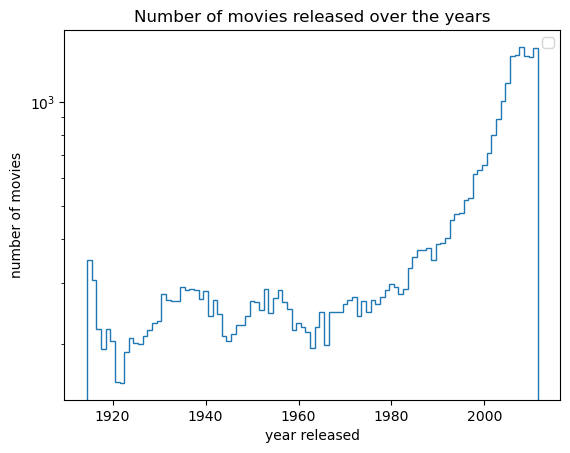

In [82]:
# plot the distribution of realese years
bins = np.arange(1915, 2013) - 0.5  # -0.5 for center-aligned bins
plt.hist(movies["year_released"], histtype="step", bins=bins, log=True)
plt.title("Number of movies released over the years")
plt.xlabel("year released")
plt.ylabel("number of movies")
plt.legend()
plt.show()

# Genre
- From the perspective of various film genres, we aim to address the following research inquiries:
    - What are the top 10 most prolific genres in the history of cinema?
    - Within the aforementioned 10 most prolific genres, which exhibit the highest proportion of exemplary films? Here, "good films" are defined as those with a rating of 7 or higher.
    - Subsequently, we delve into the intersection of genres and the temporal variable. Our objective is to identify "golden eras," characterized by periods with the highest number of highly-rated films within a given genre. This will be achieved by visualizing the count of highly-rated movies per decade.
    - Additionally, we scrutinize genre combinations to discern if specific amalgamations stand out during certain time periods. This analysis involves generating a bar chart illustrating the ratio of highly-rated movies relative to each decade.

(939,)
 "/m/07s9rl0": "Drama"                     9184
 "/m/01z4y": "Comedy"                      4958
{"/m/01jfsb": "Thriller"                   3893
{"/m/02hmvc": "Short Film"                 3573
 "/m/07s9rl0": "Drama"}                    3359
                                           ... 
 "/m/0c031k6": "Live action"                  1
{"/m/07y0lv": "Science fiction Western"       1
 "/m/0bxdv5": "Race movie"                    1
{"/m/05bdtfl": "Period Horror"                1
{"/m/02wtdps": "Crime Thriller"}              1
Name: count, Length: 939, dtype: int64


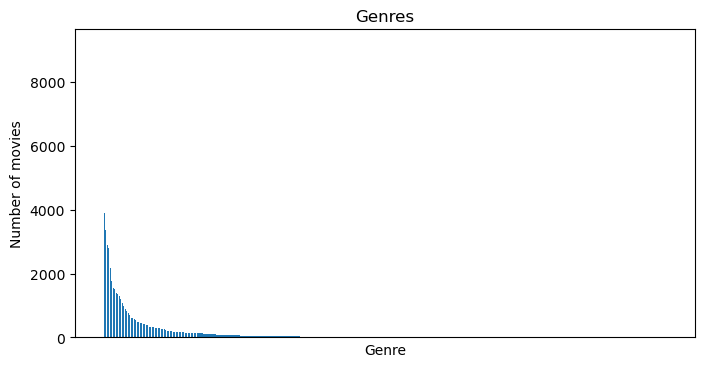

In [83]:
#genres
genres = movies["movie_genres"].str.split(",", expand=True).stack().value_counts()
print(genres.shape)
print(genres)
#plot genres
plt.figure(figsize=(8, 4))
plt.bar(genres.index, genres.values)
#hide x labels
plt.xticks([])
#plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()


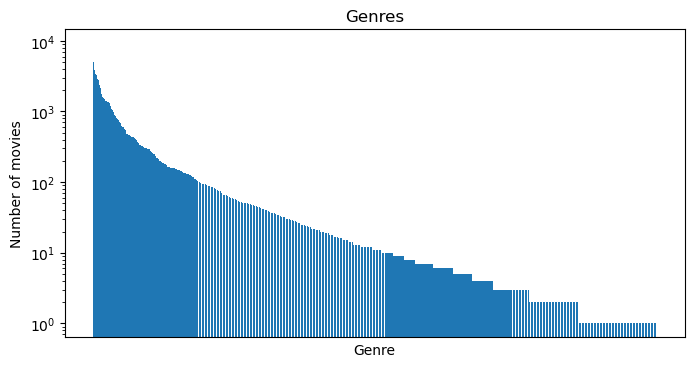

In [84]:
#use log scaling to do the above plot again
plt.figure(figsize=(8, 4))
plt.bar(genres.index, genres.values)
plt.xticks([])
#plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.yscale("log")
plt.show()


- NOTE: 
The movies dataframe includes a considerable number of niche and distinct genres that may not contribute significantly to our analysis. Notably, approximately 25% of the genres consist of only one movie, rendering them less meaningful for our purposes.

In [85]:
#extract the main genre
def extract_genres(row):
    try:
        genres_dict = json.loads(row)
        return list(genres_dict.values()) if genres_dict else ['NaN']
    except json.JSONDecodeError:
        return ['NaN']

# Apply the function to create a new 'genre' column
movies['genre'] = movies['movie_genres'].apply(extract_genres)
genre=movies['genre'].explode().copy()
genre=genre[genre!='NaN']
genre=genre.value_counts()
#find the unique genres
unique_genres = genre.index
print(unique_genres)


Index(['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Thriller',
       'Action', 'Short Film', 'Indie', 'Crime Fiction', 'Silent film',
       ...
       'Breakdance', 'Buddy Picture', 'Psychological horror', 'Chick flick',
       'C-Movie', 'Camp', 'Clay animation', 'Hardcore pornography', 'Z movie',
       'Race movie'],
      dtype='object', name='genre', length=348)


In [86]:
# give the top 10 genres that has the largerst number of movies and store them in genre_main
genre_main = genre[:10]
print(genre_main.shape)
print(genre_main.index)

(10,)
Index(['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Thriller',
       'Action', 'Short Film', 'Indie', 'Crime Fiction', 'Silent film'],
      dtype='object', name='genre')


- T-test for "main genres" selection
    - When examining the diverse genres within the dataset, we observe a high number of different genres, with certain genres covering only an insignificant number of movies. We decide to focus on the top 10 genres that have the largest number of movies and label them as the “main genres”. Here we make the assumption that the most likable genres lie within the most common, therefore the results of our analysis will not be overly biased. To validate this assumption and assess the potential impact of this bias on our subsequent results, we will conduct a T-test.


In [87]:
from scipy.stats import ttest_ind

# Sample data: Number of movies in the selected genres
main_genres_count = [genre_main[genre] for genre in genre_main.index]

# Total number of in movies_main_filtered
movies_main = movies[movies['genre'].apply(lambda x: any(item for item in x if item in genre_main.index))].copy()
movies_main_filtered= movies_main[movies_main['averageRating']>=7].copy()
total_movies = movies_main_filtered.shape[0]

# Calculate the percentage of movies in the selected genres
selected_genres_percentage = [count / total_movies * 100 for count in main_genres_count]

# Calculate the overall percentage of movies
overall_percentage = total_movies / total_movies * 100

# Perform independent t-test
t_statistic, p_value = ttest_ind(selected_genres_percentage, [overall_percentage])

# Output the results
print("Selected Genres Percentage:", selected_genres_percentage)
print("Overall Percentage:", overall_percentage)
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Check significance at a chosen alpha level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("The selection of genres significantly biases the results.")
else:
    print("There is no significant bias in the results based on the selected genres.")


Selected Genres Percentage: [646.5808823529412, 347.6102941176471, 215.0, 207.16911764705884, 183.1985294117647, 176.76470588235293, 153.97058823529412, 149.15441176470588, 140.625, 131.47058823529412]
Overall Percentage: 100.0
T-statistic: 0.8188618771371414
P-value: 0.4340116164860033
There is no significant bias in the results based on the selected genres.


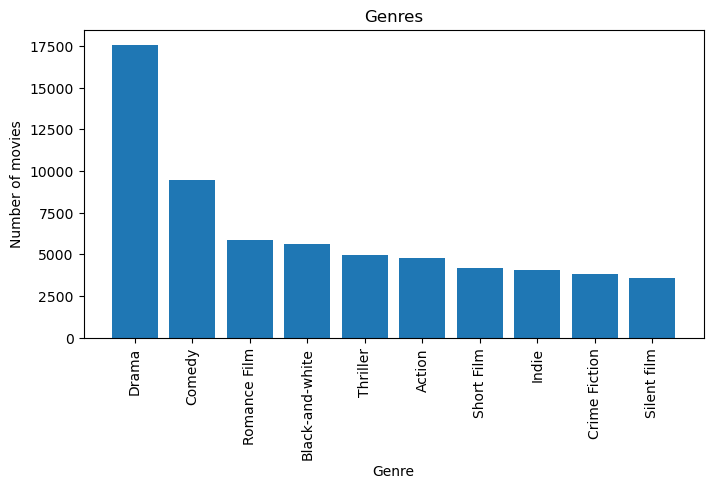

In [88]:
#plot the top 10 genres
plt.figure(figsize=(8, 4))
plt.bar(genre_main.index, genre_main.values)
plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()


In [89]:
#filter the movies that have the genres in genre_main, not necessarily the first genre
movies_main = movies[movies['genre'].apply(lambda x: any(item for item in x if item in genre_main.index))].copy()
print(movies_main.shape)
movies_main.head()


(32752, 14)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56928.0,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,NaN,NaN,NaN,"[Mystery, Biographical film, Drama, Crime Drama]"
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17.0,"[Short Film, Silent film, Indie, Black-and-whi..."
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268.0,"[Musical, Comedy, Black-and-white]"
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997,NaN,NaN,NaN,"[Romantic comedy, Ensemble Film, Comedy-drama,..."


(10,)
Index(['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Thriller',
       'Action', 'Short Film', 'Indie', 'Crime Fiction', 'Silent film'],
      dtype='object', name='genre')


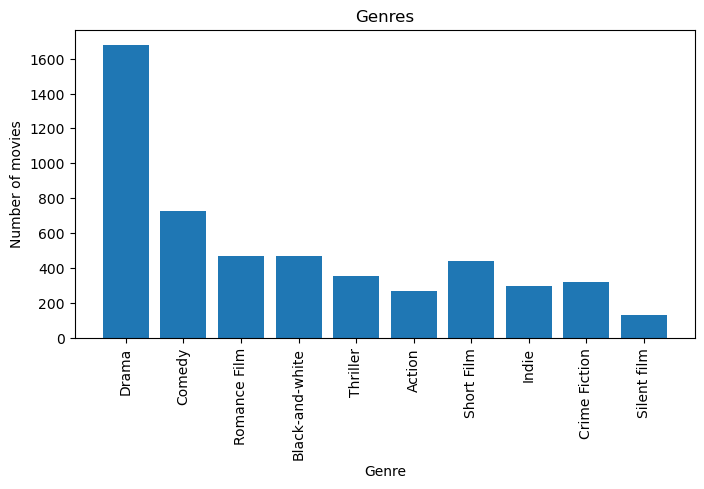

In [90]:
#filter the movies with rating higher than 7 from the movies_main dataset
movies_main_filtered= movies_main[movies_main['averageRating']>=7].copy()
#for each genre in genre_main, find the number of movies in movies_main_filter that have the genre
#and plot the number of movies for each genre
genre_main_filtered = movies_main_filtered['genre'].explode().value_counts()[genre_main.index]
print(genre_main_filtered.shape)
print(genre_main_filtered.index)
plt.figure(figsize=(8, 4))
plt.bar(genre_main_filtered.index, genre_main_filtered.values)
plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()

The graphical representation indicates that Drama exhibits a higher number of high-rated movies, primarily attributed to its extensive collection of genre movies. To provide a more nuanced evaluation, we will delve into the success_rate, defined as the ratio between the number of high-rated movies and the total number of movies within the same genre.

(10, 2)


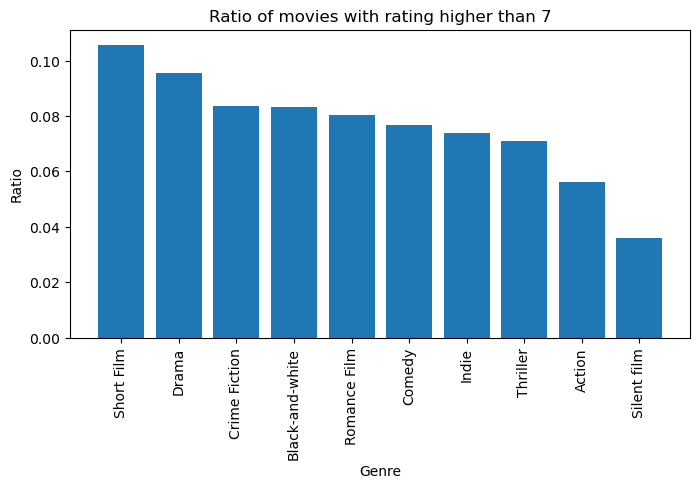

In [91]:
#for each genre, calculate the ratio of movies with rating higher than 7 / total number of movies in that genre
genre_ratio = pd.DataFrame(columns=['genre', 'ratio'])
for g in genre_main.index:
    ratio = len(movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: g in x)]) / len(movies_main[movies_main['genre'].apply(lambda x: g in x)])
    #add the genre and ratio to the dataframe
    genre_ratio = pd.concat([genre_ratio, pd.DataFrame({'genre': [g], 'ratio': [ratio]})], ignore_index=True)#sort the dataframe by ratio
genre_ratio = genre_ratio.sort_values(by='ratio', ascending=False)
print(genre_ratio.shape)
#plot the ratio
plt.figure(figsize=(8, 4))
plt.bar(genre_ratio['genre'], genre_ratio['ratio'])
plt.xticks(rotation=90)
plt.title("Ratio of movies with rating higher than 7")
plt.xlabel("Genre")
plt.ylabel("Ratio")
plt.show()


In [92]:
#create a new dataframe with only the top 10 genres and has a rating larger than 7
movies_main = movies[movies["averageRating"] >= 7].copy()
movies_main = movies_main.drop(columns=["movie_genres", "genre"])
movies_main = movies_main.reset_index(drop=True)
print(movies_main.shape)
movies_main.head()


(3247, 12)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,year_released,tconst,averageRating,numVotes
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",1989,tt0097499,7.5,31208.0
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",1964,tt0058331,7.8,181829.0
2,24399617,/m/07s63_7,Bruce Lee: The Lost Interview,1994-11-02,NaN,30.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}",1994,tt0432762,8.6,123.0
3,8669450,/m/027d9tv,One Six Right,2005-11-25,NaN,73.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",2005,tt0475994,7.9,457.0
4,164388,/m/015wmt,The Great Santini,1979-10-26,4702575.0,115.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",1979,tt0079239,7.2,6812.0


Subsequent investigations are planned to undertake a comprehensive analysis, with a specific emphasis on assessing the impact of the newly introduced time variable.

# Duration
- We aim to address this following research inquiry:
    - Are there any trends or patterns in the distribution of durations for top-rated films over the years and is there a significant difference in the distribution of durations between different genres among top-rated films?

In [93]:
#duration
#the distribution of runtime and its correlation with rating
print(movies[["movie_runtime", "averageRating"]].count())
duration = movies[["movie_runtime", "averageRating"]].dropna()
duration.count()

movie_runtime    32661
averageRating    14369
dtype: int64


movie_runtime    13609
averageRating    13609
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


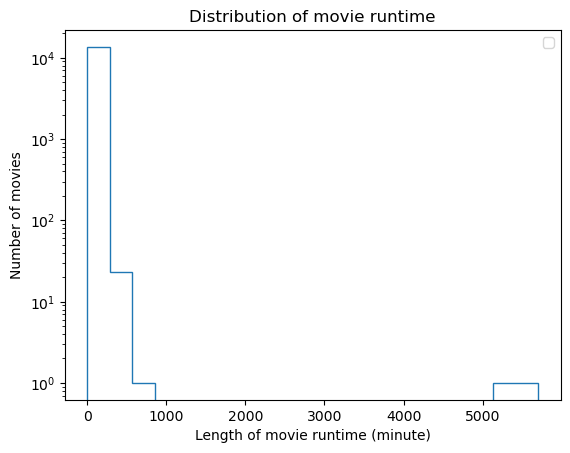

In [94]:
# histogram plot without removing outliers
plt.hist(duration["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.legend()
plt.show()


- NOTE: The dataset contains a notable number of outliers in the duration data, rendering them non-contributory to our analysis. Movies with a duration exceeding 5000 minutes are likely to encompass multiple films, introducing a potential bias to our dataset. Conversely, movies with excessively short durations do not align with our analytical focus. Consequently, we calculate the Interquartile Range (IQR) and subsequently eliminate the outliers to ensure the integrity of our data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


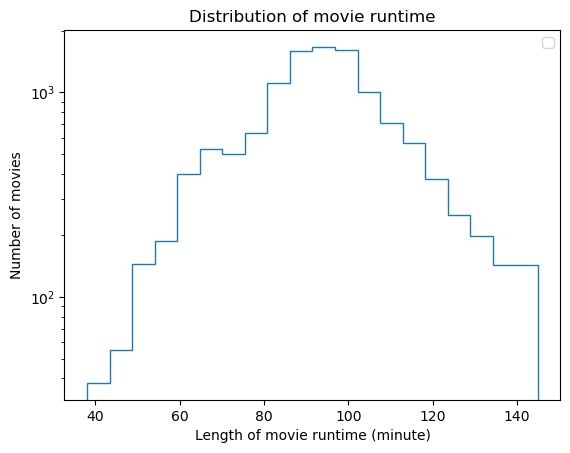

In [95]:
# histogram plot with removing outliers using IQR
q1 = duration["movie_runtime"].quantile(0.25)
q3 = duration["movie_runtime"].quantile(0.75)
iqr = q3 - q1
duration = duration[duration["movie_runtime"] < q3 + 1.5 * iqr]
duration = duration[duration["movie_runtime"] > q1 - 1.5 * iqr]

plt.hist(duration["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     374.7
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           3.26e-82
Time:                        20:57:11   Log-Likelihood:                -16873.
No. Observations:               11874   AIC:                         3.375e+04
Df Residuals:                   11872   BIC:                         3.376e+04
Df Model:                           1                                         
Covariance Type:            nonrobust  

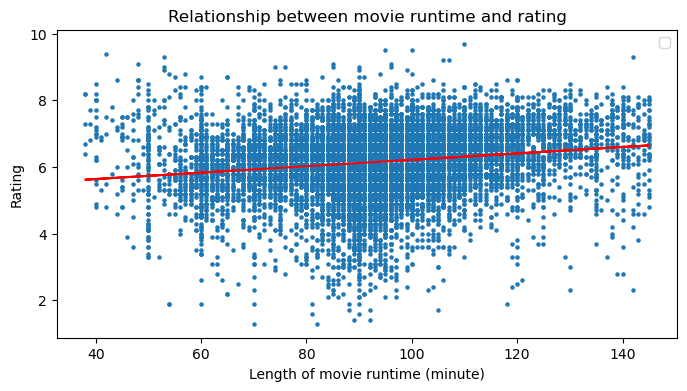

In [96]:
#perform linear regression on duration data, and plot the regression line
model=smf.ols(formula='averageRating ~ movie_runtime', data=duration)
results=model.fit()
print(results.summary())
#plot the regression line
plt.figure(figsize=(8, 4))
plt.scatter(duration["movie_runtime"], duration["averageRating"], s=5)
plt.plot(duration["movie_runtime"], results.predict(), color="red")
plt.title("Relationship between movie runtime and rating")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Rating")
plt.legend()
plt.show()


While there may be a temptation to hastily conclude a positive correlation between the duration of a movie and its rating, a more thorough examination is imperative. Given our primary objective of identifying the features characteristic of high-rated films, it is prudent to filter out movies with ratings below 7 and subsequently reassess the linear regression. This approach ensures a more focused and accurate analysis of the pertinent features influencing high movie ratings.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     10.84
Date:                Fri, 17 Nov 2023   Prob (F-statistic):            0.00101
Time:                        20:57:11   Log-Likelihood:                -1262.8
No. Observations:                2459   AIC:                             2530.
Df Residuals:                    2457   BIC:                             2541.
Df Model:                           1                                         
Covariance Type:            nonrobust  

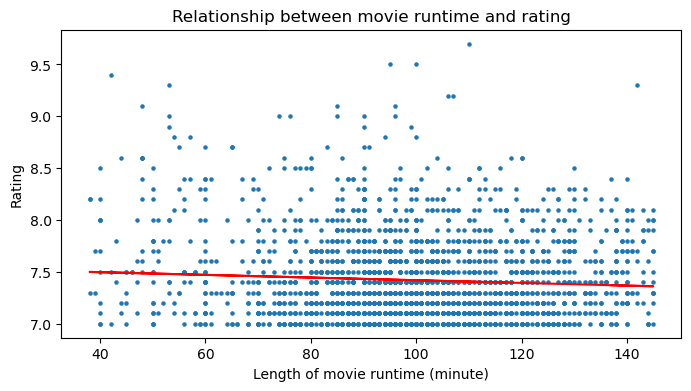

In [97]:
#filter out the movies with rating less than 7
duration = duration[duration["averageRating"] >= 7]
#perform linear regression on duration data, and plot the regression line
model=smf.ols(formula='averageRating ~ movie_runtime', data=duration)
results=model.fit()
print(results.summary())
#plot the regression line
plt.figure(figsize=(8, 4))
plt.scatter(duration["movie_runtime"], duration["averageRating"], s=5)
plt.plot(duration["movie_runtime"], results.predict(), color="red")
plt.title("Relationship between movie runtime and rating")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Rating")
plt.show()


The foregoing analysis, while informative, may not provide a definitive basis for establishing an exact correlation between duration and movie rating. In pursuit of a more nuanced understanding, we intend to explore advanced modeling techniques, including polynomial regression, to discern a more intricate relationship between movie duration and rating. This approach aims to capture potential non-linear patterns that might enhance the accuracy of our findings.

# Genre and movie runtime
Examining the trends in movie duration within each genre can provide insights into whether genre influences audience preferences for runtime. 
We ask ourselves whether it is pertinent to ask ourselves for the perfect movie duration overall or if the combination of genre and duration should be looked at together.

(10, 2)


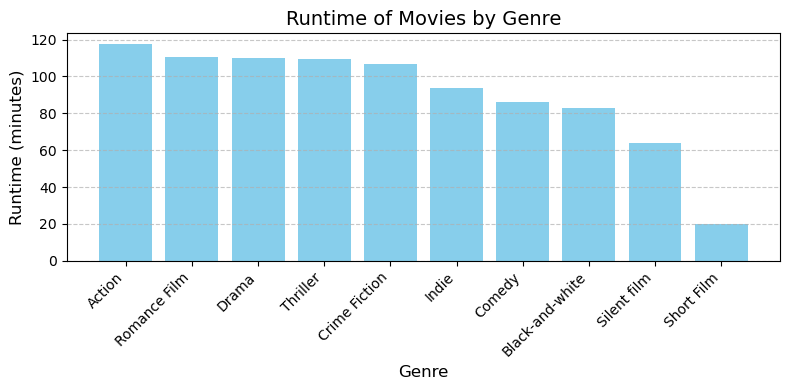

In [98]:
#for each genre, calculate the average of movies runtime
genre_runtime = pd.DataFrame(columns=['genre', 'runtime'])
for g in genre_main.index:
    #calculate runtime
    runtime = movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: g in x)]['movie_runtime'].mean()
    #add the genre and runtime to the dataframe
    genre_runtime = pd.concat([genre_runtime, pd.DataFrame({'genre': [g], 'runtime': [runtime]})], ignore_index=True)
#sort the dataframe by runtime
genre_runtime = genre_runtime.sort_values(by='runtime', ascending=False)
print(genre_runtime.shape)

# Plotting the runtime of movies by genre
plt.figure(figsize=(8, 4))

# Bar plot
plt.bar(genre_runtime['genre'], genre_runtime['runtime'], color='skyblue')

# Adjusting plot aesthetics
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Runtime of Movies by Genre", fontsize=14)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Runtime (minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
